# Variational Quantum Eigensolver (VQE) Pipeline

The **Variational Quantum Eigensolver (VQE)** is a hybrid quantum-classical algorithm for finding the ground state energy of a Hamiltonian. It leverages a **parametrized quantum circuit** and a **classical optimizer**.

## 1. Problem Definition
- Define the molecular or condensed matter system.
- Express the system's Hamiltonian in terms of Pauli operators:

  $$
  H = \sum_i c_i P_i
  $$

  where $c_i$ are real coefficients and $P_i$ are Pauli tensor products.

## 2. Ansatz Selection
- Choose a **parametrized quantum circuit** $|\psi(\theta)\rangle$ that represents the trial wavefunction.
- The ansatz should be expressive but hardware-efficient (e.g., **UCCSD**, **HEA**, etc.).

## 3. Expectation Value Estimation
- Compute the expectation value:

  $$
  E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
  $$

- Decompose $H$ into Pauli terms and measure each term individually.

## 4. Classical Optimization
- Use an **optimizer** (e.g., **SPSA, COBYLA, BFGS**) to update parameters $\theta$ to minimize $E(\theta)$.

## 5. Convergence Check
- Stop when energy difference between iterations is below a threshold:

  $$
  |E(\theta^{(t)}) - E(\theta^{(t-1)})| < \epsilon
  $$

## 6. Results & Post-Processing
- The final optimized parameters $\theta^*$ define the best approximation of the ground state.
- The final energy $E(\theta^*)$ is the estimated **ground state energy**.


In [48]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_algorithms.optimizers import SPSA

# 1. Define the backend.
backend = AerSimulator()

# 2. Define the 2-qubit ansatz.
ansatz = RealAmplitudes(3, entanglement='full', reps=1)

# 3. Create a pass manager for transpiling the circuit.
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# Transpile the ansatz (ISA: Instruction Set Architecture circuit).
isa_ansatz = pm.run(ansatz)
# (In a full application, you might apply the transpiled circuit's layout to the Hamiltonian observable.
# Here, we assume the default qubit ordering is already consistent.)

# 4. Define the Hamiltonian observable as .
observables = SparsePauliOp.from_list([
    ('IZZ', 1), ('XZI', -1.7), ('IXX', 1.02), ('YII', -0.3), ('IIZ', 0.5)
])

# 5. Create an estimator using the chosen backend.
estimator = EstimatorV2()

# 6. Define the energy cost function.
def energy_cost_function(params):
    # Bind the parameters to the transpiled ansatz.
    state = isa_ansatz.assign_parameters(params)
    # Since the circuit is fully parameter-bound, we pass None for the parameters.
    job = estimator.run([(state, observables, None)])
    energy = job.result()[0].data.evs.item()
    return energy

# 7. Define a callback to monitor intermediate energy values.
results = []
paramlist = []
def optimizer_callback(iter, params,energy, *args,**kwargs):
    results.append(energy)
    paramlist.append(params)
    print(f"Intermediate energy: {energy}")

# 8. Define the optimizer (using SPSA).
optimizer = SPSA(maxiter=50, callback=optimizer_callback)

# 9. Choose an initial guess for the parameters.
initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
# 10. Run the optimization.
opt_result = optimizer.minimize(energy_cost_function, initial_params)



Intermediate energy: 0.3725623165952767
Intermediate energy: -0.45558706069998284
Intermediate energy: -0.6750385964578538
Intermediate energy: -1.7222996368870156
Intermediate energy: 1.138829962843695
Intermediate energy: -0.15801956963733807
Intermediate energy: -0.2594485727386056
Intermediate energy: -0.3502972045345387
Intermediate energy: -0.4053789425622389
Intermediate energy: -0.6037894151712888
Intermediate energy: -0.6037642110434508
Intermediate energy: -0.6621731249899784
Intermediate energy: -1.0974816986581166
Intermediate energy: -1.1048731197423824
Intermediate energy: -1.445558047644399
Intermediate energy: -2.2915403703556043
Intermediate energy: -2.3169572458767194
Intermediate energy: -2.703093739921462
Intermediate energy: -2.7140078279380404
Intermediate energy: -2.860521149477611
Intermediate energy: -2.861292252544912
Intermediate energy: -3.0401050895458055
Intermediate energy: -3.106143036742274
Intermediate energy: -3.12947351026608
Intermediate energy: -3.

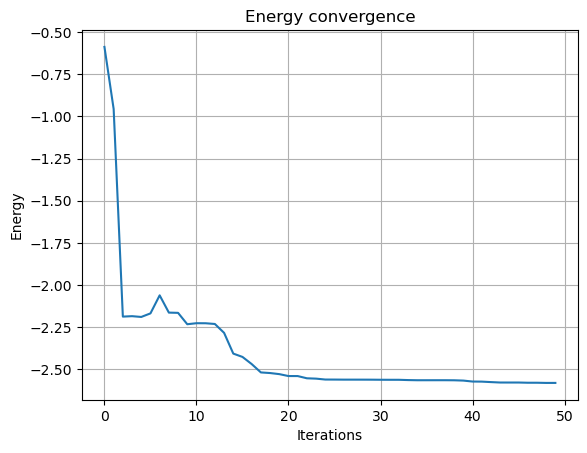

In [47]:
import matplotlib.pyplot as plt

plt.plot(results)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.show()

Here is the corrected final markdown section:

---

### Summary and Explanation

1. **Backend and Transpilation:**  
   - We use `AerSimulator` as the backend for simulation.  
   - The ansatz is transpiled using a preset pass manager with `optimization_level=3`.  
   - Transpilation ensures the circuit is optimized and mapped to the backend's native gate set.  

2. **Ansatz Construction:**  
   - The ansatz is a 3-qubit `RealAmplitudes` circuit with full entanglement and one repetition.  
   - This circuit prepares a variational trial state $|\psi(\theta)\rangle$, where $\theta$ are tunable parameters.  

3. **Hamiltonian Definition:**  
   - The Hamiltonian for this system is defined as:  
     $$
     H = \text{IZZ} + (-1.7)\,\text{XZI} + 1.02\,\text{IXX} + (-0.3)\,\text{YII} + 0.5\,\text{IIZ}.
     $$
   - Each term represents a Pauli observable acting on specific qubits.  

4. **Expectation Value Estimation:**  
   - The `EstimatorV2` primitive computes the expectation value:  
     $$
     \langle \psi(\theta)| H |\psi(\theta)\rangle.
     $$
   - The ansatz circuit is bound to parameters before execution.  

5. **Optimization Process:**  
   - The cost function evaluates the expectation value for given parameters.  
   - The SPSA optimizer minimizes this cost function iteratively.  
   - A callback function records and prints intermediate energy values.  

6. **Final Results:**  
   - The optimizer returns the optimal parameters and the estimated ground state energy.  
   - The lowest energy found approximates the Hamiltonian’s ground state energy.  
